In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [3]:
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)
trainset_augment = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)

# train loader has batch size 256 since we want to not overruse our data
trainloader_augment = torch.utils.data.DataLoader(
    trainset_augment, batch_size=256, shuffle=True, num_workers=16
)

# test loader has bigger batch size since we care only about efficiency
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1024, shuffle=False, num_workers=16
)


Files already downloaded and verified
Files already downloaded and verified


In [16]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(128)
        self.conv4_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(256)
        self.conv5_1 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv5_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 32, 3, padding=1)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(self.conv2_bn(F.relu(self.conv2(x))), 2)
        x = F.relu(self.conv3_1(x))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = F.max_pool2d(F.relu(self.conv4_1(x)), 2)
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = F.max_pool2d(F.relu(self.conv5_1(x)), 2)
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = F.relu(self.conv6(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x
        


def train_net(
        net: Net,
        net_optimizer: torch.optim.Optimizer,
        data_tensor: torch.Tensor,
        label_tensor: torch.Tensor,
) -> float:
    net.train()
    device = next(net.parameters()).device

    data_tensor = data_tensor.to(device)
    label_tensor = label_tensor.to(device)

    net_optimizer.zero_grad()

    pred_label = net(data_tensor)

    loss = F.cross_entropy(pred_label, label_tensor)
    loss.backward()

    net_optimizer.step()

    return float(loss.item())

def get_avg_loss_accuracy(
        net: Net,
        data_loader: torch.utils.data.DataLoader,
) -> tuple[float, float]:
    net.eval()
    device = next(net.parameters()).device
    with torch.no_grad():
        test_loss = 0.0
        ncorrect = 0
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred_label = net(inputs)
            loss = F.cross_entropy(pred_label, labels)
            test_loss += loss.item()
            ncorrect += (pred_label.argmax(dim=1) == labels).sum().item()
    return test_loss / len(data_loader), ncorrect / len(data_loader.dataset)

In [17]:
import typing
def make_training_iterator(loader: torch.utils.data.DataLoader, epochs: int) -> typing.Iterator[tuple[int, torch.Tensor, torch.Tensor]]:
    for epoch in range(epochs):
        for data, label in loader:
            yield epoch, data, label

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr=5e-4)

train_iter = make_training_iterator(trainloader_augment, 200)

net_step = 0
net_losses = []
net_test_losses = []

In [19]:
for _, inputs, labels in train_iter:
    # train on minibatch
    loss = train_net(net, optimizer, inputs, labels)
    net_losses.append(loss)
    net_step += 1
    # validation loss
    if net_step % 100 == 0:
        test_loss, _ = get_avg_loss_accuracy(net, testloader)
        net_test_losses.append(test_loss)
    # print statistics
    if net_step % 1000 == 0:
        loss = np.mean(net_losses[-1000:])
        print(f"Step: {net_step}, Loss: {loss:.6f}")

print('Finished Training')

Step: 1000, Loss: 1.043983
Step: 2000, Loss: 0.551424
Step: 3000, Loss: 0.398281


KeyboardInterrupt: 

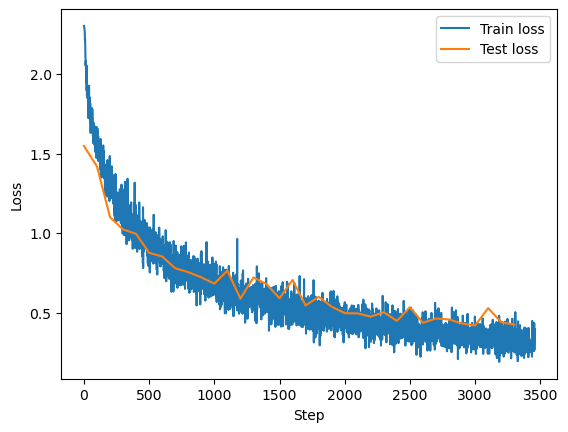

In [23]:
plt.plot(net_losses, label="Train loss")
plt.plot(np.arange(0, len(net_test_losses) * 100, 100), net_test_losses, label="Test loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
_, test_accuracy = get_avg_loss_accuracy(net, testloader)

print(f'Accuracy of the network on the {len(testset)} test images: {100 * test_accuracy:.2f}%')

Accuracy of the network on the 10000 test images: 86.53%
